# Short notebook

Kaggle: "I love your NaN(s)" - (public score:142.136697, jallasatck2.csv)

Rory Fitzgerald, roryf (540995), 

Henrik Horpedal, henrhorp (564667)

Peter Pham, phpham (527659)

### Helper functions and classes

In [1]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
import pandas as pd
import os

In [2]:
RANDOM_STATE = 69
#np.random.seed(RANDOM_STATE)
FOLDER_NAME = "SHORT_NOTEBOOK1_CSV_FILES"
GLOBAL_VERBOSE = False
PREPROCESSORS = ["quarters","statistical", "trimmedMean"]
LETTERS = ["A", "B", "C"]
if not os.path.exists(FOLDER_NAME):
    os.makedirs(FOLDER_NAME)

#### Preprocessing

In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import PredefinedSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# using a class to mimic a namespace:
class pre:

    def clean_NaN(df):
        df = df.copy()
        df.dropna(subset=['target'], inplace=True)
        return df

    def remove_long_sequences(df, col_name, seq_len):
        df = df.copy()
        # Identify sequences of zeros
        df['group'] = (df[col_name] != 0).cumsum()
        df['group_count'] = df.groupby('group')[col_name].transform('count')
        
        # Create a mask to identify rows with sequences longer than seq_len and isshadow lower than 1
        mask = (df[col_name] == 0) & (df['group_count'] > seq_len) #& (df['is_in_shadow:idx'] < 1)
        
        # Remove rows with sequences longer than seq_len and isshadow lower than 1
        df_cleaned = df[~mask].drop(columns=['group', 'group_count'])
        return df_cleaned.copy()


    def remove_repeating_nonzero(df, col_name, repeat_count=5):
        df = df.copy()
        # create a mask to identify rows with repeating nonzero values in the target column
        mask = ((df[col_name] != 0) & (df[col_name].shift(1) == df[col_name]))
        # create a mask to identify rows with repeating nonzero values that occur more than repeat_count times
        repeat_mask = mask & (mask.groupby((~mask).cumsum()).cumcount() >= repeat_count)
        # create a mask to identify the complete sequence of repeating nonzero values
        seq_mask = repeat_mask | repeat_mask.shift(-5)
        # remove rows with repeating nonzero values that occur more than repeat_count times
        df = df[~seq_mask]
        return df

    def clean(df):
        df = df.copy()
        df=pre.clean_NaN(df)
        df=pre.remove_long_sequences(df, 'target', 60)
        df=pre.remove_repeating_nonzero(df, 'target')
        return df


    def encode(data, col, max_val):
        data = data.copy()
        data = data.copy()
        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
        return data

    def create_time_features(df):
        df = df.copy()
        df["hour"]=df.index.hour
        df["dayofyear"]=df.index.dayofyear
        df["month"]=df.index.month
        df["week"] = df.index.isocalendar().week

        #zero indexing:
        df["dayofyear"]-=1
        df["month"]-=1
        df["week"]-=1


        #Cycling the time features:
        df = pre.encode(df, "hour", 24)
        df = pre.encode(df, "month", 12)
        df = pre.encode(df, "week", 53)
        df = pre.encode(df, "dayofyear", 366)

        df.drop(columns=["hour", "month", "week", "dayofyear"], inplace=True)


        df["mult1"]=(1-df["is_in_shadow:idx"])*df['direct_rad:W']
        df["mult2"]=(1-df["is_in_shadow:idx"])*df['clear_sky_rad:W']
        df["date_calc"]=pd.to_datetime(df["date_calc"])
        df.index=pd.to_datetime(df.index)
        df["uncertainty"]=(df.index-df["date_calc"]).apply(lambda x: x.total_seconds()/3600)
        df["uncertainty"].fillna(0, inplace=True)
        return df

    def create_features(df):
        df = df.copy()

        df.dropna(subset=['absolute_humidity_2m:gm3'], inplace=True)
        df["total_solar_rad"]=df["direct_rad:W"]+df["diffuse_rad:W"]
        #df["clear_sky_%"]=df["total_solar_rad"]/df["clear_sky_rad:W"]*100
        #df["clear_sky_%"].fillna(0, inplace=True)
        df["spec humid"]=df["absolute_humidity_2m:gm3"]/df["air_density_2m:kgm3"]
        df["temp*total_rad"]=df["t_1000hPa:K"]*df["total_solar_rad"]
        df["wind_angle"]=(np.arctan2(df["wind_speed_u_10m:ms"],df["wind_speed_v_10m:ms"]))*180/np.pi
        #df["total_snow_depth"] = df["snow_depth:cm"] + df["fresh_snow_1h:cm"]
        #df["total_precip_5min"] = df["precip_5min:mm"] + df["snow_melt_10min:mm"]
        #df["total_precip_type"] = df["precip_type_5min:idx"] + df["snow_water:kgm2"]
        df["total_pressure"] = df["pressure_50m:hPa"] + df["pressure_100m:hPa"]
        df["total_sun_angle"] = df["sun_azimuth:d"] + df["sun_elevation:d"]
        df["solar intensity"]=1361*np.cos(np.radians(90-df["sun_elevation:d"]))
        df["solar intensity"].clip(lower=0, inplace=True)
        return df

    def shift_target(df, target_col):
        df = df.copy()
        # Ensure the DataFrame is indexed by date
        df.index = pd.to_datetime(df.index)

        # Store the original indices
        original_indices = df.index

        # Reindex the DataFrame to include all 15-minute intervals
        all_intervals = pd.date_range(start=df.index.min(), end=df.index.max(), freq='15T')
        df = df.reindex(all_intervals)

        # Shift the target variable by 1 period (15 minutes) forward and backward
        df[target_col + '_shifted_forward'] = df[target_col].shift(-1)
        df[target_col + '_shifted_backward'] = df[target_col].shift(1)

        # Forward fill the missing values for the forward shift
        df[target_col + '_shifted_forward'].fillna(method='ffill', inplace=True)

        # Backward fill the missing values for the backward shift
        df[target_col + '_shifted_backward'].fillna(method='bfill', inplace=True)

        # Keep only the original indices
        df = df.loc[original_indices]

        return df


    def add_lagged_features(df):
        df = df.copy()
        features_to_lag = [ "total_solar_rad", "temptotal_rad", "clear_sky_radW", "diffuse_radW", "direct_radW",  "total_cloud_coverp", "solarintensity", "total_sun_angle", "pressure_100mhPa"] #these were the most important features, and therefore assumed to be the most important to lag 
        
        for feature in features_to_lag:
            df = pre.shift_target(df, feature)

        return df



    #experiments showed that flaml preformed slightly better with fewer features, no lagged features:
    def general_read_flaml(letter):
        df = pd.read_parquet(f"{letter}/X_train_observed.parquet")
        df2=pd.read_parquet(f"{letter}/X_train_estimated.parquet")
        y = pd.read_parquet(f"{letter}/train_targets.parquet")
        # set the index to date_forecast and group by hourly frequency
        df.set_index("date_forecast", inplace=True)
        df2.set_index("date_forecast", inplace=True)
        y.set_index("time", inplace=True)

        df.index = pd.to_datetime(df.index)
        df2.index = pd.to_datetime(df2.index)
        y.index = pd.to_datetime(y.index) 
        
        df=pd.concat([df,df2],axis=0)

        # truncate y to match the index of df
        y = y.truncate(before=df.index[0], after=df.index[-1])
        latest_y_time = y.index[-1]
        latest_needed_df_time = latest_y_time + pd.Timedelta(minutes=45)
        # Truncate y based on df
        y = y.truncate(before=df.index[0], after=df.index[-1])
        # Ensure df has all needed entries from the start of y to 45 minutes after the end of y
        df = df.truncate(before=y.index[0], after=latest_needed_df_time)
        y.rename(columns={"pv_measurement":"target"},inplace=True)
        X = df.copy()
        Y = y.copy()
        #drop nan rows in Y
        Y = pre.clean(Y)
        X.index = pd.to_datetime(X.index)
        Y.index = pd.to_datetime(Y.index)

        X_filtered = X[X.index.floor('H').isin(Y.index)]

        # Step 2: Ensure there are exactly four 15-min intervals for each hour
        valid_indices = X_filtered.groupby(X_filtered.index.floor('H')).filter(lambda group: len(group) == 4).index

        # Final filtered X
        X_final = X[X.index.isin(valid_indices)]


        #Troubleshooting: Find and print the hours with a mismatch
        group_sizes = X_filtered.groupby(X_filtered.index.floor('H')).size()
        mismatch_hours = group_sizes[group_sizes != 4]

        #Additional troubleshooting: find hours in Y without four 15-min intervals in X
        missing_hours_in_x = Y.index[~Y.index.isin(X_filtered.index.floor('H'))]


        #Remove mismatched and missing hours from Y
        all_issues = mismatch_hours.index.union(missing_hours_in_x)
        Y_clean = Y[~Y.index.isin(all_issues)]

        #dropping nan columns:
        X_final = X_final.drop(columns=['cloud_base_agl:m'])
        X_final = X_final.drop(columns=['ceiling_height_agl:m'])
        X_final = X_final.drop(columns=['snow_density:kgm3'])

        X_final = pre.create_features(X_final)
        X_final = pre.create_time_features(X_final)
        X_final.drop(columns=['date_calc'], inplace=True)

        X_final = X_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        Y_clean = Y_clean.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

        #X_final = add_lagged_features(X_final)

        # Split X_final into a list of 4-row DataFrames
        X_grouped = [group for _, group in X_final.groupby(X_final.index.floor('H')) if len(group) == 4]
        
        # Ensure we only take the groups of X corresponding to Y_clean
        X_list = [X_grouped[i] for i in range(len(Y_clean))]

        return X_list, Y_clean


    def general_read(letter):

        df = pd.read_parquet(f"{letter}/X_train_observed.parquet")
        df2=pd.read_parquet(f"{letter}/X_train_estimated.parquet")
        y = pd.read_parquet(f"{letter}/train_targets.parquet")
        # set the index to date_forecast and group by hourly frequency
        df.set_index("date_forecast", inplace=True)
        df2.set_index("date_forecast", inplace=True)
        y.set_index("time", inplace=True)

        df.index = pd.to_datetime(df.index)
        df2.index = pd.to_datetime(df2.index)
        y.index = pd.to_datetime(y.index) 
        
        df=pd.concat([df,df2],axis=0)

        # truncate y to match the index of df
        y = y.truncate(before=df.index[0], after=df.index[-1])
        latest_y_time = y.index[-1]
        latest_needed_df_time = latest_y_time + pd.Timedelta(minutes=45)
        # Truncate y based on df
        y = y.truncate(before=df.index[0], after=df.index[-1])
        # Ensure df has all needed entries from the start of y to 45 minutes after the end of y
        df = df.truncate(before=y.index[0], after=latest_needed_df_time)
        y.rename(columns={"pv_measurement":"target"},inplace=True)
        X = df.copy()
        Y = y.copy()
        #drop nan rows in Y
        Y = pre.clean(Y)
        X.index = pd.to_datetime(X.index)
        Y.index = pd.to_datetime(Y.index)

        X_filtered = X[X.index.floor('H').isin(Y.index)]

        # Step 2: Ensure there are exactly four 15-min intervals for each hour
        valid_indices = X_filtered.groupby(X_filtered.index.floor('H')).filter(lambda group: len(group) == 4).index

        # Final filtered X
        X_final = X[X.index.isin(valid_indices)]


        #Troubleshooting: Find and print the hours with a mismatch
        group_sizes = X_filtered.groupby(X_filtered.index.floor('H')).size()
        mismatch_hours = group_sizes[group_sizes != 4]

        #Additional troubleshooting: find hours in Y without four 15-min intervals in X
        missing_hours_in_x = Y.index[~Y.index.isin(X_filtered.index.floor('H'))]


        #Remove mismatched and missing hours from Y
        all_issues = mismatch_hours.index.union(missing_hours_in_x)
        Y_clean = Y[~Y.index.isin(all_issues)]

        #dropping nan columns:
        X_final = X_final.drop(columns=['cloud_base_agl:m'])
        X_final = X_final.drop(columns=['ceiling_height_agl:m'])
        X_final = X_final.drop(columns=['snow_density:kgm3'])

        X_final = pre.create_features(X_final)
        X_final = pre.create_time_features(X_final)
        X_final.drop(columns=['date_calc'], inplace=True)

        X_final = X_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        Y_clean = Y_clean.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

        X_final = pre.add_lagged_features(X_final)

        # Split X_final into a list of 4-row DataFrames
        X_grouped = [group for _, group in X_final.groupby(X_final.index.floor('H')) if len(group) == 4]
        
        # Ensure we only take the groups of X corresponding to Y_clean
        X_list = [X_grouped[i] for i in range(len(Y_clean))]

        return X_list, Y_clean


    #the general read function returns a list of 4-row DataFrames, that was in order to have the same lenght of X and Y, therefore this function was needed.
    def concatenate_dfs(df_list):
        """
        Concatenates a list of DataFrames into a single DataFrame.

        Args:
        df_list (list of pd.DataFrame): List of DataFrame objects to concatenate.

        Returns:
        pd.DataFrame: A single DataFrame containing all rows from the input DataFrames in the order they appear in the list.
        """
        return pd.concat(df_list, ignore_index=False)

    #preprocessor which could be used in a pipeline:
    class QuartersAsColumnsTransformer(BaseEstimator, TransformerMixin):
        def fit(self, X, y=None):
            return self
        
        def transform(self, X, y=None):
            # Ensure input is a DataFrame
            X = X.copy()
            assert isinstance(X, pd.DataFrame)
            #make sure index is datetime:
            X.index = pd.to_datetime(X.index)

            original_index = X.index


            X['hour'] = X.index.floor('H')
            X['minute'] = X.index.minute

            # Melt the DataFrame to long format
            df_melted = pd.melt(X, id_vars=['hour', 'minute'], value_vars=X.columns[:-2]).copy()  # excluding 'hour' and 'minute'

            # Create a multi-level column name combining variable and minute
            df_melted['variable_minute'] = df_melted['variable'] + '_' + df_melted['minute'].astype(str) + 'min'

            # Drop the 'variable_minute' column


            # Pivot the data to get one row per hour and columns for each variable and minute
            X = df_melted.pivot(index='hour', columns='variable_minute', values='value').copy()
            #rename index to date_forecast:
            X.index.rename("date_forecast", inplace=True)


            #drop irrelevant columns:
            #hour_sin	hour_cos	month_sin	month_cos	week_sin	week_cos	dayofyear_sin	dayofyear_cos	mult1	mult2	uncertainty


            irrelevant_cols = ["hour_sin", "hour_cos", "month_sin", "month_cos", "week_sin", "week_cos", "dayofyear_sin", "dayofyear_cos", "uncertainty"]
            variantes = ["_0min", "_15min", "_30min", "_45min"]
            for variant in variantes:
                for col in irrelevant_cols:
                    if variant == "_0min":
                        #remove _0min from column name;
                        X.rename(columns={col+variant:col}, inplace=True)
                    else:
                        X.drop(columns=[col+variant], inplace=True)
            

            reindex_map = original_index.floor('H').unique()
            X = X.reindex(reindex_map)
            X.index = reindex_map

            #drop hour_

            if "object" in X.dtypes.unique():
                print("waring: object in QuarterAsColumnsTransformer")
                print(X.dtypes.unique())
                for col in X.columns:
                    print(col)

            #X = X.select_dtypes(include=[np.number])
            return X
        
    #preprocessor which could be used in a pipeline:
    class StatisticalFeaturesTransformer(BaseEstimator, TransformerMixin):
        def fit(self, X, y=None):
            return self

        def transform(self, X, y=None):
            X_copy = X.copy()
            X_copy.index = pd.to_datetime(X_copy.index)
            X_copy['hour'] = X_copy.index.floor('H')
            
            # Compute mean, std
            aggregated = X_copy.groupby('hour').agg(['mean', 'std'])
            
            # Filter hours with exactly 4 data points
            valid_hours = X_copy.groupby('hour').size()
            valid_hours = valid_hours[valid_hours == 4].index
            
            X_final = aggregated.loc[valid_hours]
            
            # Flatten the multi-index to form new column names
            X_final.columns = ['_'.join(col).strip() for col in X_final.columns.values]
            # for col in X_final.columns:
            #     print(col)
            #drop minute_mean and minute_std if they exist:
            if "minute_mean" in X_final.columns:
                X_final.drop(columns=["minute_mean", "minute_std"], inplace=True)
            
            X_final = X_final.select_dtypes(include=[np.number])
            # print(X_final.dtypes.unique())
            # for col in X_final.columns:
            #     print(col)


            return X_final
        
    

    class HourMonthTargetEncoder(BaseEstimator, TransformerMixin):
        def __init__(self):
            self.encoding_map = {}
            self.y_ = None  # To store y during fit

        def fit(self, X, y=None):
            # Ensure X's index is a datetime index
            if not isinstance(X.index, pd.DatetimeIndex):
                raise ValueError("Index of input X must be a pandas DatetimeIndex")

            if y is None:
                raise ValueError("y cannot be None for fitting the encoder")

            # Store the target values for encoding later
            self.y_ = y

            try:
                # Extract hour and month from the index and use y provided during fit
                df = pd.DataFrame({'target': self.y_, 'hour': X.index.hour, 'month': X.index.month})
            except Exception as e:
                raise e

            # Compute mean target value for each hour of each month
            self.encoding_map = df.groupby(['month', 'hour'])['target'].mean().to_dict()
            return self

        def transform(self, X):
            # Ensure X's index is a datetime index
            if not isinstance(X.index, pd.DatetimeIndex):
                raise ValueError("Index of input X must be a pandas DatetimeIndex")

            if self.y_ is None:
                raise ValueError("The encoder has not been fitted with target values")

            # Extract hour and month from the index
            X_transformed = X.copy()
            X_transformed['hour'] = X.index.hour
            X_transformed['month'] = X.index.month

            # Map the mean target values
            X_transformed['target_encoded'] = X_transformed.apply(
                lambda row: self.encoding_map.get((row['month'], row['hour']), np.nan), axis=1)

            # Optionally drop 'hour' and 'month' if they're not needed
            X_transformed.drop(['hour', 'month'], axis=1, inplace=True)

            # Check for object dtypes and print warning if any
            if "object" in X_transformed.dtypes.values:
                print("Warning: object dtype in HourMonthTargetEncoder")
                print(X_transformed.dtypes)

            # Ensure that only numeric types are returned
            X_transformed = X_transformed.select_dtypes(include=[np.number])

            return X_transformed




    def apply_preprocessor(data, preprocessor_name):
        data = data.copy()
        # Assuming `pre.choose_transformer` returns a callable object that can be used to transform the data
        preprocessor = pre.choose_transformer(preprocessor_name)
        return preprocessor.transform(data)

    


    def train_test_split_may_june_july(X, y,letter):
        """
        Splits the data based on a given date. Additionally, moves May, June and July data of split_date's year
        from training set to test set.
        
        Parameters:
        - X: Quarter-hourly input data with DateTime index.
        - y: Hourly target data with DateTime index.
        - split_date: Date (string or datetime object) to split the data on.
        
        Returns:
        X_train, y_train, X_test, y_test
        """

        if letter == "A":
            year = 2022
        elif letter == "B":
            year = 2019
        elif letter == "C":
            year = 2020
        
        # Define conditions to move May and June of split_date's year from train to test
        may_june_july_condition_X = ((X.index.month == 5) | (X.index.month == 6) | (X.index.month == 7)) & ((X.index.year == year))
        may_june_july_condition_y = ((y.index.month == 5) | (y.index.month == 6) | (y.index.month == 7)) & ((y.index.year == year))
        
        X_may_june_july = X[may_june_july_condition_X]
        y_may_june_july = y[may_june_july_condition_y]

        # Remove May and June data from training set
        X_train = X[~may_june_july_condition_X]
        y_train = y[~may_june_july_condition_y]

        return X_train, y_train, X_may_june_july, y_may_june_july
    



    def new_train_test_split(X, y,letter, split_date):
        """
        Splits the data based on a given date. Additionally, moves May, June and July data of split_date's year
        from training set to test set.
        
        Parameters:
        - X: Quarter-hourly input data with DateTime index.
        - y: Hourly target data with DateTime index.
        - split_date: Date (string or datetime object) to split the data on.
        
        Returns:
        X_train, y_train, X_test, y_test
        """
        split_date = pd.Timestamp(split_date).normalize()
        print(f"Split date: {split_date}")

        if isinstance(split_date, str):
            split_date = pd.Timestamp(split_date)
        if letter == "A":
            year = 2022
        elif letter == "B":
            year = 2019
        elif letter == "C":
            year = 2020

        X_train = X[X.index.normalize() < split_date]
        y_train = y[y.index.normalize() < split_date]

        X_test = X[X.index.normalize() >= split_date]
        y_test = y[y.index.normalize() >= split_date]
        
        # Define conditions to move May and June of split_date's year from train to test
        may_june_july_condition_X = ((X.index.month == 5) | (X.index.month == 6) | (X.index.month == 7)) & ((X.index.year == year))
        may_june_july_condition_y = ((y.index.month == 5) | (y.index.month == 6) | (y.index.month == 7)) & ((y.index.year == year))
        
        X_may_june_july = X[may_june_july_condition_X]
        y_may_june_july = y[may_june_july_condition_y]

        # Remove May and June data from training set
        X_train = X[~may_june_july_condition_X]
        y_train = y[~may_june_july_condition_y]

        # Append May and June data to test set
        X_test = pd.concat([X_may_june_july, X_test])
        y_test = pd.concat([y_may_june_july, y_test])

        return X_train, y_train, X_test, y_test


    def choose_scaler(scaler_string):
        if scaler_string == "minmax":
            return MinMaxScaler()
        elif scaler_string == "standard":
            return StandardScaler()
        elif scaler_string == "robust":
            return RobustScaler()

    def choose_transformer(transformer_string):
        if transformer_string == "quarters":
            return pre.QuartersAsColumnsTransformer()
        elif transformer_string == "statistical":
            return pre.StatisticalFeaturesTransformer()
        elif transformer_string == "trimmedMean":
            return pre.TrimmedMeanTransformer()

    def choose_encoder(encoder_boolian):
        if encoder_boolian == True:
            return pre.HourMonthTargetEncoder()
        else:
            return None

    def generate_predefined_split(X_train, X_val, y_train, y_val):
        """
        This function takes in separate training and validation datasets, combines them,
        and creates a PredefinedSplit object that can be used with sklearn's GridSearchCV
        or other model selection utilities. This allows for specifying which samples are
        used for training and which are used for validation.

        Parameters:
        X_train (array-like): Training features.
        X_val (array-like): Validation features.
        y_train (array-like): Training labels.
        y_val (array-like): Validation labels.

        Returns:
        X (array-like): The combined dataset of features.
        y (array-like): The combined dataset of labels.
        split_index (PredefinedSplit): An instance of PredefinedSplit with the indices set.
        """

        # Combine the training and validation sets
        X = np.concatenate((X_train, X_val), axis=0)
        y = np.concatenate((y_train, y_val), axis=0)

        # Generate the indices array where -1 indicates the sample is part of the training set,
        # and 0 indicates the sample is part of the validation set.
        train_indices = -1 * np.ones(len(X_train))
        val_indices = 0 * np.ones(len(X_val))
        test_fold = np.concatenate((train_indices, val_indices))

        # Create the PredefinedSplit object
        predefined_split = PredefinedSplit(test_fold)

        return X, y, predefined_split




class ensPre:
    def preptest(df,features_list,stats_dict):
        df.drop(columns=["ceiling_height_agl:m","snow_density:kgm3","cloud_base_agl:m"],inplace=True)
        df=ensPre.create_features(df)
        #df=unleash_hell(df)
        df=ensPre.create_time_features(df)
        #df=df[features_list[:-1]]
        df=ensPre.cyclical_features(df)
        df=ensPre.add_stats_features(df, stats_dict)
        df=ensPre.shift_target(df,"total_solar_rad")
        df.dropna(inplace=True)
        df.columns = ["".join(c if c.isalnum() or c == '_' else '_' for c in str(x)) for x in df.columns]

        return df
    def readDataSet(letter):
        # read X_train_observed.parquet file for the current letter
        df = pd.read_parquet(f"{letter}/X_train_observed.parquet")
        
        df2=pd.read_parquet(f"{letter}/X_train_estimated.parquet")
        
        # set the index to date_forecast and group by hourly frequency
        df.set_index("date_forecast", inplace=True)
        df.index = pd.to_datetime(df.index)
        df = df.groupby(df.index.date).resample('H').max().reset_index(level=0, drop=True)
        df2.set_index("date_forecast", inplace=True)
        df2.index = pd.to_datetime(df2.index)
        df2 = df2.groupby(df2.index.date).resample('H').max().reset_index(level=0, drop=True)
        y = pd.read_parquet(f"{letter}/train_targets.parquet")
        y.set_index("time", inplace=True)
        y.index = pd.to_datetime(y.index)

        df=pd.concat([df,df2],axis=0)

        df = df.truncate(before=y.index[0], after=y.index[-1])
        y=y.truncate(before=df.index[0], after=df.index[-1])
        df=pd.concat([df,y],axis=1)
        df.rename(columns={"pv_measurement":"target"},inplace=True)

        
        return df

    def readtest(letter):
        df = pd.read_parquet(f"{letter}/X_test_estimated.parquet")
        df.set_index("date_forecast", inplace=True)
        df.index = pd.to_datetime(df.index)
        df = df.groupby(df.index.date).resample('H').max().reset_index(level=0, drop=True)
        return df
    def cleanNaN(df):
        df.dropna(subset=['target'], inplace=True)
        return df
    # define a function to remove rows with sequences longer than 50 zeros
    #remove NaN first to avoid NaN 0 sequence not being removed
    def remove_long_sequences(df, col_name, seq_len):
        # Identify sequences of zeros
        df['group'] = (df[col_name] != 0).cumsum()
        df['group_count'] = df.groupby('group')[col_name].transform('count')
        
        # Create a mask to identify rows with sequences longer than seq_len and isshadow lower than 1
        mask = (df[col_name] == 0) & (df['group_count'] > seq_len) & (df['is_in_shadow:idx'] < 1)
        
        # Remove rows with sequences longer than seq_len and isshadow lower than 1
        df_cleaned = df[~mask].drop(columns=['group', 'group_count'])
        return df_cleaned.copy()
    
    def remove_repeating_nonzero(df, col_name, repeat_count=5):
        # create a mask to identify rows with repeating nonzero values in the target column
        mask = ((df[col_name] != 0) & (df[col_name].shift(1) == df[col_name]))
        # create a mask to identify rows with repeating nonzero values that occur more than repeat_count times
        repeat_mask = mask & (mask.groupby((~mask).cumsum()).cumcount() >= repeat_count)
        # create a mask to identify the complete sequence of repeating nonzero values
        seq_mask = repeat_mask | repeat_mask.shift(-5)
        # remove rows with repeating nonzero values that occur more than repeat_count times
        df = df[~seq_mask]
        return df
    def clean(df):
        df=ensPre.cleanNaN(df)
        df=ensPre.remove_long_sequences(df, 'target', 30)
        df=ensPre.remove_repeating_nonzero(df, 'target')
        #df=remove_outliers_hourly_and_month(df, 'target')
        return df
    def remove_outliers_hourly_and_month(df, target_col):
        for month in range (1,13):
            df_month = df[df.index.month == month]
            for i in range(24):
                df_hour=df_month[df_month.index.hour == i]
                Q1 = df_hour[target_col].quantile(0.25)
                Q3 = df_hour[target_col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                df_hour_rem = df_hour[(df_hour[target_col] >= lower_bound) & (df_hour[target_col] <= upper_bound)]
                if i==0:
                    df_rem=df_hour_rem
                else:
                    df_rem=pd.concat([df_rem,df_hour_rem],axis=0)
            if month==1:
                df_rem_month=df_rem
            else:
                df_rem_month=pd.concat([df_rem_month,df_rem],axis=0)
        df_rem_month.sort_index(inplace=True)
        return df_rem_month
    def calculate_hourly_monthly_means(df):
        # Ensure the DataFrame is indexed by date
        df.index = pd.to_datetime(df.index)
        
        # Create new columns for the hour and the month
        df['hour'] = df.index.hour
        df['month'] = df.index.month

        # Calculate the mean of the target variable for each hour during each month
        stats = df.groupby(['month', 'hour'])['target'].agg(['mean', 'std'])

        # Convert the DataFrame to a dictionary of dictionaries
        stats_dict = stats.to_dict('index')

        return stats_dict

    def add_stats_features(df, stats_dict):
        df["month"]=df.index.month
        df["hour"]=df.index.hour
        df['mean'] = df.apply(lambda row: stats_dict[(row['month'], row['hour'])]['mean'], axis=1)
        df['std'] = df.apply(lambda row: stats_dict[(row['month'], row['hour'])]['std'], axis=1)

        return df

    def cyclical_features(df):
        df["hour_sin"] = np.sin(df.index.hour*(2.*np.pi/24))
        df["hour_cos"] = np.cos(df.index.hour*(2.*np.pi/24))
        df["dayofyear_sin"] = np.sin(df.index.dayofyear*(2.*np.pi/365))
        df["dayofyear_cos"] = np.cos(df.index.dayofyear*(2.*np.pi/365))
        return df.copy()
        


    def create_time_features(df):
        df["hour"]=df.index.hour
        #df["week"]=df.index.isocalendar().week
        df["dayofyear"]=df.index.dayofyear
        df["month"]=df.index.month
        df["mult1"]=(1-df["is_in_shadow:idx"])*df['direct_rad:W']
        df["mult2"]=(1-df["is_in_shadow:idx"])*df['clear_sky_rad:W']
        df["date_calc"]=pd.to_datetime(df["date_calc"])
        df.index=pd.to_datetime(df.index)
        df["uncertainty"]=(df.index-df["date_calc"]).apply(lambda x: x.total_seconds()/3600)
        df["uncertainty"].fillna(0, inplace=True)
        df.drop(columns=["date_calc"],inplace=True)
        return df.copy()

    def trim(df,features_list):
        df.drop(columns=["ceiling_height_agl:m","snow_density:kgm3","cloud_base_agl:m"],inplace=True)
        df=ensPre.clean(df)
        df=ensPre.create_features(df)
        #df=unleash_hell(df)
        df=ensPre.create_time_features(df)
        #df=df[features_list]
        df=ensPre.cyclical_features(df)
        stats_dict=ensPre.calculate_hourly_monthly_means(df)
        df=ensPre.add_stats_features(df, stats_dict)
        df=ensPre.shift_target(df,"total_solar_rad")

        df.dropna(inplace=True)
        #df = df[~df.index.month.isin([1, 2, 11, 12])]

        return df

    def create_features(df):

        df.dropna(subset=['absolute_humidity_2m:gm3'], inplace=True)

        df["total_solar_rad"]=df["direct_rad:W"]+df["diffuse_rad:W"]

        #df["clear_sky_%"]=df["total_solar_rad"]/df["clear_sky_rad:W"]*100
        #df["clear_sky_%"].fillna(0, inplace=True)
        df["spec humid"]=df["absolute_humidity_2m:gm3"]/df["air_density_2m:kgm3"]
        df["temp*total_rad"]=df["t_1000hPa:K"]*df["total_solar_rad"]
        df["wind_angle"]=(np.arctan2(df["wind_speed_u_10m:ms"],df["wind_speed_v_10m:ms"]))*180/np.pi
        #df["total_snow_depth"] = df["snow_depth:cm"] + df["fresh_snow_1h:cm"]
        #df["total_precip_5min"] = df["precip_5min:mm"] + df["snow_melt_10min:mm"]
        #df["total_precip_type"] = df["precip_type_5min:idx"] + df["snow_water:kgm2"]
        df["total_pressure"] = df["pressure_50m:hPa"] + df["pressure_100m:hPa"]
        df["total_sun_angle"] = df["sun_azimuth:d"] + df["sun_elevation:d"]
        df["solar intensity"]=1361*np.cos(np.radians(90-df["sun_elevation:d"]))
        df["solar intensity"].clip(lower=0, inplace=True)
        df["cloud"]=df["clear_sky_rad:W"]-df["total_solar_rad"]
        df["cloud2"]=df["clear_sky_rad:W"]*(1-df["effective_cloud_cover:p"])
        df['temp*total_rad_squared'] = df['temp*total_rad']**2
        df['total_solar_rad_squared']=df['total_solar_rad']**2
        df['t_1000hPa:K_daystd']=df['t_1000hPa:K'].groupby(df.index.date).transform('std')
        df['wind_angle_squared']=df['wind_angle']**2

        return df.copy()

    def unleash_hell(df):
        cols=df.columns
        new_cols=[]
        for col in cols:
            if col=="target" or col=="date_calc":
                continue
            new_cols.append(df[col].groupby(df.index.date).transform('max').rename(f"{col}_daymax"))
            new_cols.append(df[col].groupby(df.index.date).transform('min').rename(f"{col}_daymin"))
            new_cols.append(df[col].groupby(df.index.date).transform('mean').rename(f"{col}_daymean"))
            new_cols.append(df[col].groupby(df.index.date).transform('std').rename(f"{col}_daystd"))
            new_cols.append(df[col].groupby(df.index.date).transform('sum').rename(f"{col}_daysum"))
            #new_cols.append(pd.Series(np.log(1+df[col].values + 1e-8), index=df.index, name=f"{col}_log")) # convert numpy array to pandas Series
            new_cols.append((df[col]**2).rename(f"{col}_squared"))
        """
        for col1, col2 in itertools.combinations(cols, 2):
            new_cols.append((df[col1] + df[col2]).rename(f"{col1}+{col2}"))
            new_cols.append((df[col1] - df[col2]).rename(f"{col1}-{col2}"))
            new_cols.append((df[col1] * df[col2]).rename(f"{col1}*{col2}"))
            new_cols.append((df[col1] / df[col2]).rename(f"{col1}/{col2}"))
        """
        df = pd.concat([df] + new_cols, axis=1)
        return df.copy()
            
    def shift_target(df, target_col):
        # Ensure the DataFrame is indexed by date
        df.index = pd.to_datetime(df.index)

        # Store the original indices
        original_indices = df.index

        # Reindex the DataFrame to include all hours
        all_hours = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
        df = df.reindex(all_hours)

        # Shift the target variable by 1 hour forward and backward
        df[target_col + '_shifted_forward'] = df[target_col].shift(-1)
        df[target_col + '_shifted_backward'] = df[target_col].shift(1)

        # Forward fill the missing values for the forward shift
        df[target_col + '_shifted_forward'].ffill(inplace=True)

        # Backward fill the missing values for the backward shift
        df[target_col + '_shifted_backward'].bfill(inplace=True)

        # Keep only the original indices
        df = df.loc[original_indices]

        return df
    
    
    def new_train_test_split(X, y,letter,holdout=False):
        """
        Splits the data based on a given date. Additionally, moves May, June and July data of split_date's year
        from training set to test set.
        
        Parameters:
        - X: Quarter-hourly input data with DateTime index.
        - y: Hourly target data with DateTime index.
        - split_date: Date (string or datetime object) to split the data on.
        
        Returns:
        X_train, y_train, X_test, y_test
        """
        Len=len(X)
        Lensum=len(X[(X.index.month == 5) | (X.index.month == 6) | (X.index.month == 7)])
        X=pd.concat([X,y],axis=1)
    

        # Convert index to DatetimeIndex object
        X.index = pd.to_datetime(X.index)

        num_samples = int(0.05 * len(X))
        fraction = num_samples / len(X[(X.index.month == 5) | (X.index.month == 6) | (X.index.month == 7)])
        X_test = X[(X.index.month == 5) | (X.index.month == 6) | (X.index.month == 7)].sample(frac=fraction, random_state=69)

        X = X.drop(X_test.index)

        if holdout:
            X_holdout=X[(X.index.month == 5) | (X.index.month == 6) | (X.index.month == 7)].sample(frac=fraction*2, random_state=69)
            X_train = X.drop(X_holdout.index)
            y_holdout=X_holdout["target"]
            X_holdout=X_holdout.drop(columns=["target"])
        else:
            X_train = X
            y_holdout = None
            X_holdout = None

        

        # Remove May and June data from training set
        y_train=X_train["target"]
        y_test=X_test["target"]
        X_train=X_train.drop(columns=["target"])
        X_test=X_test.drop(columns=["target"])

        return X_train, X_test, y_train, y_test, X_holdout, y_holdout

#### Postprocessing

In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import os


class post:    
    def readRawTest(letter):
        df = pd.read_parquet(f"{letter}/X_test_estimated.parquet")
        df.set_index("date_forecast", inplace=True)
        df.index = pd.to_datetime(df.index)
        return df

    def readAndBasicPreprocess(letter):
        X = post.readRawTest(letter)
        X.drop(columns=['cloud_base_agl:m'], inplace=True)
        X.drop(columns=['ceiling_height_agl:m'], inplace=True)
        X.drop(columns=['snow_density:kgm3'], inplace=True)
        X=pre.create_features(X)
        X=pre.create_time_features(X)
        X.drop(columns=['date_calc'], inplace=True)
        X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        X = pre.add_lagged_features(X)
        return X

    def makePrediction(A_model, B_model, C_model, filename):
        A_x_test = post.readAndBasicPreprocess("A")
        A_y_pred=A_model.predict(A_x_test)
        A_y_pred=pd.DataFrame(A_y_pred, index=range(0,720), columns=['prediction'])

        B_x_test= post.readAndBasicPreprocess("B")
        B_y_pred=B_model.predict(B_x_test)
        B_y_pred=pd.DataFrame(B_y_pred, index=range(720,1440), columns=['prediction'])

        C_x_test= post.readAndBasicPreprocess("C")
        C_y_pred=C_model.predict(C_x_test)
        C_y_pred=pd.DataFrame(C_y_pred, index=range(1440,2160), columns=['prediction'])

        combined_pred = pd.concat([A_y_pred, B_y_pred, C_y_pred], axis=0)
        combined_pred["prediction"] = combined_pred["prediction"].clip(lower=0)
        combined_pred.index.name = "id"
        combined_pred.to_csv(filename, index=True)

    
    def make_dnn_prediction(A_model, A_preprocessing, A_target_scaling, B_model, B_preprocessing, B_target_scaling, C_model, C_preprocessing, C_target_scaling, filename):
        A_X_test = post.readAndBasicPreprocess("A")
        A_X_test_dnn = pd.DataFrame(A_preprocessing.transform(A_X_test))
        A_y_pred_dnn = A_model.predict(A_X_test_dnn)
        A_y_pred_dnn = A_target_scaling.inverse_transform(A_y_pred_dnn).reshape(-1)
        A_y_pred = pd.DataFrame(A_y_pred_dnn, index=range(0,720), columns=['prediction'])

        B_X_test = post.readAndBasicPreprocess("B")
        B_X_test_dnn = pd.DataFrame(B_preprocessing.transform(B_X_test))
        B_y_pred_dnn = B_model.predict(B_X_test_dnn)
        B_y_pred_dnn = B_target_scaling.inverse_transform(B_y_pred_dnn).reshape(-1)
        B_y_pred = pd.DataFrame(B_y_pred_dnn, index=range(720,1440), columns=['prediction'])

        C_X_test = post.readAndBasicPreprocess("C")
        C_X_test_dnn = pd.DataFrame(C_preprocessing.transform(C_X_test))
        C_y_pred_dnn = C_model.predict(C_X_test_dnn)
        C_y_pred_dnn = C_target_scaling.inverse_transform(C_y_pred_dnn).reshape(-1)
        C_y_pred = pd.DataFrame(C_y_pred_dnn, index=range(1440,2160), columns=['prediction'])

        combined_pred = pd.concat([A_y_pred, B_y_pred, C_y_pred], axis=0)
        combined_pred["prediction"] = combined_pred["prediction"].clip(lower=0)
        combined_pred.index.name = "id"
        combined_pred.to_csv(filename, index=True)



    def compute_mae(ser1, ser2):
        """Compute Mean Absolute Error between two Series."""
        return np.abs(ser1 - ser2).mean()

    def plot_mae_grid(dataframes_dict):
        """Plot a grid of MAE values for a dictionary of DataFrames."""
        
        labels = list(dataframes_dict.keys())
        dataframes = list(dataframes_dict.values())
        n = len(dataframes)
        
        mae_grid = np.zeros((n, n))

        for i in range(n):
            for j in range(n):
                if i != j:
                    mae_grid[i][j] = post.compute_mae(dataframes[i]["prediction"], dataframes[j]["prediction"])

        fig, ax = plt.subplots(figsize=(10, 8))
        cax = ax.matshow(mae_grid, cmap="viridis")
        
        ax.grid(False)
        plt.xticks(range(n), labels, rotation=45)
        plt.yticks(range(n), labels)
        
        # Add annotations
        for i in range(n):
            for j in range(n):
                text = ax.text(j, i, f"{mae_grid[i, j]:.2f}",
                            ha="center", va="center", color="w" if mae_grid[i, j] > (mae_grid.max() / 2) else "black")
        
        plt.colorbar(cax)
        plt.title('MAE Between DataFrames on "prediction" Column', pad=20)
        plt.show()

    def makePredictionWithModelAndPreprocessor(A_model, B_model, C_model, preprocessor, filename):
        """
        Assumes same preprocessing for all locations

        """

        A_X_test = post.readAndBasicPreprocess("A")
        A_X_test = preprocessor.transform(A_X_test)
        A_y_pred = A_model.predict(A_X_test)
        A_y_pred = pd.DataFrame(A_y_pred, index=range(0,720), columns=['prediction'])

        B_X_test = post.readAndBasicPreprocess("B")
        B_X_test = preprocessor.transform(B_X_test)
        B_y_pred = B_model.predict(B_X_test)
        B_y_pred = pd.DataFrame(B_y_pred, index=range(720,1440), columns=['prediction'])

        C_X_test = post.readAndBasicPreprocess("C")
        C_X_test = preprocessor.transform(C_X_test)
        C_y_pred = C_model.predict(C_X_test)
        C_y_pred = pd.DataFrame(C_y_pred, index=range(1440,2160), columns=['prediction'])

        combined_pred = pd.concat([A_y_pred, B_y_pred, C_y_pred], axis=0)
        combined_pred["prediction"] = combined_pred["prediction"].clip(lower=0)
        combined_pred.index.name = "id"
        combined_pred.to_csv(filename, index=True)



    def make_average_prediction(preds_dict,filename):
        """
        Generates a prediction by taking the average of the predictions in preds_dict.
        """
        lenght = len(preds_dict)
        data = 0
        for value in preds_dict.values():
            data += value["prediction"]
        data = data / lenght
        data = pd.DataFrame(data, columns=['prediction'])
        data.index.name = "id"
        data["prediction"] = data['prediction'].apply(lambda x: 0 if x < 0.1 else x)
        data.loc[(data.index % 24).isin([22, 23, 0]), "prediction"] = 0
        data.to_csv(filename, index=True)

### Deep Neural Network with tuned hyperparameters

#### Defining The DNN:

In [5]:
import torch
import torch.nn as nn
#impoting lightning:
import pytorch_lightning as pl
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
import numpy as np
import pandas as pd
import torch.nn.functional as F
#import dataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as DataSet
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import random
from pytorch_lightning import seed_everything

SEED = 69
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.use_deterministic_algorithms(True)
g = torch.Generator()
g.manual_seed(SEED)



def seed_worker(worker_id):
    worker_seed = SEED
    np.random.seed(worker_seed)
    random.seed(worker_seed)

class SolarForecastingDataset(DataSet):
    def __init__(self, features_df, target_series):
        """
        Initializes the dataset with features and target labels.

        :param features_df: DataFrame containing the features.
        :param target_series: Series containing the target labels.
        """
        self.features = features_df
        self.targets = target_series

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        # Extracting the features and the target label for the given index
        feature_vector = self.features.iloc[index].values
        target_label = self.targets.iloc[index]

        return {
            "feature_vector": torch.tensor(feature_vector, dtype=torch.float),
            "target_label": torch.tensor(target_label, dtype=torch.float)
        }

class SolarForecastingDatasetDataModule(pl.LightningDataModule):
    def __init__(self, train_features_df, train_targets_series, test_features_df, test_targets_series, batch_size=8):
        super().__init__()
        self.train_features_df = train_features_df
        self.train_targets_series = train_targets_series
        self.test_features_df = test_features_df
        self.test_targets_series = test_targets_series
        self.batch_size = batch_size

        
    def setup(self, stage=None):
        self.train_dataset = SolarForecastingDataset(self.train_features_df, self.train_targets_series)
        self.test_dataset = SolarForecastingDataset(self.test_features_df, self.test_targets_series)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,worker_init_fn=seed_worker, generator=g, shuffle=True,)

    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=1, shuffle=False, worker_init_fn=seed_worker, generator=g)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=1, shuffle=False, worker_init_fn=seed_worker, generator=g)

class FullyConnectedDNN(nn.Module):
    def __init__(self, input_size, layer_sizes, output_size, dropout_prob=0.1):
        super(FullyConnectedDNN, self).__init__()
        # Create fully connected layers
        self.fc_layers = nn.ModuleList()
        for i in range(len(layer_sizes)):
            in_features = input_size if i == 0 else layer_sizes[i - 1]
            out_features = layer_sizes[i]
            self.fc_layers.append(nn.Linear(in_features, out_features))

        self.output_layer = nn.Linear(layer_sizes[-1], output_size)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        for layer in self.fc_layers:
            x = F.relu(layer(x))
            x = self.dropout(x)
        x = self.output_layer(x)
        return x

def weighted_mae_loss(input, target, exponent=1, constant=1):
    assert input.size() == target.size()

    # Calculate the absolute error
    absolute_errors = torch.abs(input - target)

    # Apply exponential scaling with a constant
    adjusted_target = target + constant
    weighted_errors = absolute_errors * (adjusted_target ** exponent)

    return weighted_errors.mean()


class SolarPowerProductionPredictor(pl.LightningModule):

    def __init__(self, input_size, layer_sizes, output_size, weight_decay=1e-5, dropout_prob=0.1, learning_rate=0.01, verbose=True, loss_exponent=1.0, loss_beta=1.0):
        super().__init__()
        self.model = FullyConnectedDNN(input_size, layer_sizes, output_size, dropout_prob=dropout_prob)
        self.criterion = self.criterion = lambda input, target: weighted_mae_loss(input, target, exponent=loss_exponent, constant=1)
        #self.criterion = CustomMAELoss(loss_alpha, loss_beta)

        self.weight_decay = weight_decay
        self.learning_rate = learning_rate
        self.verbose = verbose
    
    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output

    def training_step(self, batch, batch_idx):
        features, labels = batch["feature_vector"], batch["target_label"]
        loss, outputs = self(features, labels) 
        self.log("train_loss", loss, prog_bar=self.verbose, logger=False)
        return loss
    
    def validation_step(self, batch, batch_idx):
        features, labels = batch["feature_vector"], batch["target_label"]
        loss, outputs = self(features, labels) 
        self.log("val_loss", loss, prog_bar=self.verbose, logger=False)
        return loss
    
    def test_step(self, batch, batch_idx):
        features, labels = batch["feature_vector"], batch["target_label"]
        loss, outputs = self(features, labels) 
        self.log("test_loss", loss, prog_bar=self.verbose, logger=False)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)



class CustomModelCheckpoint(ModelCheckpoint):
    def on_save_checkpoint(self, trainer, pl_module, checkpoint):
        # Save the best model path to the pl_module
        pl_module.best_model_path = self.best_model_path

def get_predictions(model, dataloader):
    model.eval()  # set the model to evaluation mode
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            features, labels = batch["feature_vector"], batch["target_label"]
            predictions = model(features)[1]  
            if not isinstance(predictions, torch.Tensor):
                raise TypeError("Model output is not a tensor. Got type: {}".format(type(predictions)))
            
            all_predictions.append(predictions)
            all_labels.append(labels)

    # Check for tensor types before concatenation
    if not all(isinstance(p, torch.Tensor) for p in all_predictions):
        raise TypeError("Not all elements in predictions are tensors.")

    if not all(isinstance(l, torch.Tensor) for l in all_labels):
        raise TypeError("Not all elements in labels are tensors.")

    all_predictions_tensor = torch.cat(all_predictions, dim=0)
    all_labels_tensor = torch.cat(all_labels, dim=0)

    # Convert tensors to numpy arrays
    all_predictions_np = all_predictions_tensor.cpu().numpy()
    all_labels_np = all_labels_tensor.cpu().numpy()
    
    return all_predictions_np, all_labels_np

class HenrikDNN:

    def __init__(self,n_features = None, layer_sizes = [100,50], output_size = 1, drop_out_prob = 0.1, learning_rate = 0.01, weight_decay = 1e-5, max_epochs = 100, paitience = 5, batch_size = 16, val_chack_interval = 1, pruning_callback = None, verbose = True, loss_expontent = 1):

        self.n_features = n_features
        self.layer_sizes = layer_sizes
        self.verbose = verbose
        self.output_size = output_size
        self.drop_out_prob = drop_out_prob
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.loss_expontent = loss_expontent
        self.paitience = paitience
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.val_chack_interval = val_chack_interval
        self.pruning_callback = pruning_callback
        SEED = 69
        torch.manual_seed(SEED)
        np.random.seed(SEED)
        random.seed(SEED)
        torch.use_deterministic_algorithms(True)
        g = torch.Generator()
        g.manual_seed(SEED)


        self.pl_model = SolarPowerProductionPredictor(self.n_features, self.layer_sizes, self.output_size, weight_decay=self.weight_decay, dropout_prob=self.drop_out_prob, learning_rate=self.learning_rate, verbose=self.verbose, loss_exponent=self.loss_expontent)

        self.checkpoint_callback = CustomModelCheckpoint(
            dirpath='HenrikDNN_checkpoints',
            save_top_k=1,
            verbose=self.verbose,
            monitor='val_loss',
            mode='min',
            filename='model-{epoch:02d}-{val_loss:.2f}'
        )

        self.early_stopping_callback = EarlyStopping(
            monitor="val_loss",
            patience=self.paitience
        )


        self.callbacks = [self.early_stopping_callback, self.checkpoint_callback]
        if self.pruning_callback is not None:
            self.callbacks.append(self.pruning_callback)
        seed_everything(69, workers=True)

        self.trainer = pl.Trainer(
            max_epochs=self.max_epochs,
            callbacks=self.callbacks,
            enable_progress_bar=self.verbose,
            accelerator="cpu",
            check_val_every_n_epoch = 2,
            deterministic=True

            #val_check_interval=self.val_chack_interval
        )

    def train(self, X_train, y_train, X_val, y_val):
        """
        Args:
            X_train: Training df with datetime index. 
            y_train: Training df, with datetime index. Each row in y_train corresponds to four rows in X_train.
    
        """
        #print the seed:
        SEED = 69
        print("hei")
        torch.manual_seed(SEED)
        np.random.seed(SEED)
        random.seed(SEED)
        torch.use_deterministic_algorithms(True)
        g = torch.Generator()
        g.manual_seed(SEED)

        self.data_module = SolarForecastingDatasetDataModule(X_train, y_train, X_val, y_val, batch_size=self.batch_size)
        self.trainer.fit(self.pl_model, self.data_module)


    def predict(self, X):
        trained_model = SolarPowerProductionPredictor.load_from_checkpoint(
            self.pl_model.best_model_path,
            input_size=self.n_features,
            layer_sizes=self.layer_sizes,
            output_size=self.output_size,
            dropout_prob=self.drop_out_prob,
            learning_rate=self.learning_rate,
            weight_decay=self.weight_decay,
            verbose=self.verbose,
            loss_exponent=self.loss_expontent
        )

        X_dataloader = torch.utils.data.DataLoader(
            SolarForecastingDataset(X, pd.Series(np.zeros(X.shape[0]))),
            batch_size=1,
            shuffle=False,
            num_workers=0,
            worker_init_fn=seed_worker,
            generator=g
        )

        predictions, _ = get_predictions(trained_model, X_dataloader)

        return predictions



def train_test_split_on_specific_day_May_june(X, y, split_date):
    """
    Splits the data based on a given date. Additionally, moves May, June and July data of split_date's year
    from training set to test set.
    
    Parameters:
    - X: Quarter-hourly input data with DateTime index.
    - y: Hourly target data with DateTime index.
    - split_date: Date (string or datetime object) to split the data on.
    
    Returns:
    X_train, y_train, X_test, y_test
    """
    split_date = pd.Timestamp(split_date).normalize()

    # Ensure split_date is a datetime object
    if isinstance(split_date, str):
        split_date = pd.Timestamp(split_date)

    print(f"Split date: {split_date}")

    # Split the data based on the provided date
    X_train = X[X.index.normalize() < split_date]
    y_train = y[y.index.normalize() < split_date]

    X_test = X[X.index.normalize() >= split_date]
    y_test = y[y.index.normalize() >= split_date]

    # Define conditions to move May and June of split_date's year from train to test
    may_june_condition_X = ((X_train.index.month == 5) | (X_train.index.month == 6) | (X_train.index.month == 7)) & (X_train.index.year == split_date.year)
    may_june_condition_y = ((y_train.index.month == 5) | (y_train.index.month == 6) | (y_train.index.month == 7)) & (y_train.index.year == split_date.year)
    
    X_may_june = X_train[may_june_condition_X]
    y_may_june = y_train[may_june_condition_y]

    # Remove May and June data from training set
    X_train = X_train[~may_june_condition_X]
    y_train = y_train[~may_june_condition_y]

    # Append May and June data to test set
    X_test = pd.concat([X_may_june, X_test])
    y_test = pd.concat([y_may_june, y_test])

    return X_train, y_train, X_test, y_test


In [6]:
def trainDNN(letter):
    X, y = pre.general_read(letter)
    X = pre.concatenate_dfs(X)
    X_train, y_train,X_val, y_val = pre.train_test_split_may_june_july(X,y , letter)
    y_train = y_train["target"]
    y_val = y_val["target"]

    if letter == "A":

        dnn_params = {
            'layer_sizes': [119,101], #<----- from opta hyper parameter tuning
            'drop_out_prob': 0.03, #<----- from opta hyper parameter tuning
            'learning_rate': 0.0000969995972939842, #<----- from opta hyper parameter tuning
            'loss_expontent': 0.9702228408589507, #<----- from opta hyper parameter tuning
            'max_epochs': 300, #
            'paitience': 15, #
            'batch_size': 128, #
            'val_chack_interval': 0.5, #
            'verbose': False,
            'weight_decay': 2.499126185711371e-8 #<----- from opta hyper parameter tuning
        }

        dnn_feature_scaler = 'minmax' #<----- from opta hyper parameter tuning
        dnn_target_scaler = 'minmax' #<----- from opta hyper parameter tuning
        dnn_preprocessor = 'quarters' #<----- from opta hyper parameter tuning
        dnn_target_encoder = True #<----- from opta hyper parameter tuning
    
    elif letter == "B":
        
        dnn_params = {
            'layer_sizes': [200,180], #<----- from opta hyper parameter tuning
            'drop_out_prob': 0.03, #<----- from opta hyper parameter tuning
            'learning_rate': 0.000018846485346070986, #<----- from opta hyper parameter tuning
            'loss_expontent': 0.963895316469423, #<----- from opta hyper parameter tuning
            'max_epochs': 300, #
            'paitience': 15, #
            'batch_size': 128, #
            'val_chack_interval': 0.5, #
            'verbose': False,
            'weight_decay': 6.586949775384596e-7 #<----- from opta hyper parameter tuning
        }
        
        dnn_feature_scaler = 'minmax'
        dnn_target_scaler = 'minmax'
        dnn_preprocessor = 'statistical'
        dnn_target_encoder = False
    
    elif letter == "C":
        #52.31801357204807	quarters	true	144	131	0.000060363753946263044	-1.5104000124283146	2.335809622586189e-7
        dnn_params = {
            'layer_sizes': [144,131], #<----- from opta hyper parameter tuning
            'drop_out_prob': 0.03, #<----- from opta hyper parameter tuning
            'learning_rate': 0.000060363753946263044, #<----- from opta hyper parameter tuning
            'loss_expontent': -1.5104000124283146, #<----- from opta hyper parameter tuning
            'max_epochs': 300, #
            'paitience': 15, #
            'batch_size': 128, #
            'val_chack_interval': 0.5, #
            'verbose': False,
            'weight_decay': 2.335809622586189e-7 #<----- from opta hyper parameter tuning
        }

        dnn_feature_scaler = 'minmax'
        dnn_target_scaler = 'minmax'
        dnn_preprocessor = 'quarters'
        dnn_target_encoder = True

    dnn_feature_scaler = pre.choose_scaler(dnn_feature_scaler)
    dnn_target_scaler = pre.choose_scaler(dnn_target_scaler)
    dnn_preprocessor = pre.choose_transformer(dnn_preprocessor)
    dnn_target_encoder = pre.choose_encoder(dnn_target_encoder)
    
    dnn_preprocessing = Pipeline([
        ('custom_transformer', dnn_preprocessor),
        ('target_encoder', dnn_target_encoder), 
        ('feature_scaler', dnn_feature_scaler)
    ])

    dnn_target_preprocessing = Pipeline([
        ('target_scaler', dnn_target_scaler)
    ])

    #fit the preprocessing:
    dnn_preprocessing.fit(X_train, y_train)
    dnn_target_preprocessing.fit(pd.DataFrame(y_train))

    #transform the data:
    X_train_dnn = pd.DataFrame((dnn_preprocessing.transform(X_train)))
    y_train_dnn = pd.DataFrame(dnn_target_preprocessing.transform(pd.DataFrame(y_train)))
    X_val_dnn = pd.DataFrame(dnn_preprocessing.transform(X_val))
    y_val_dnn = pd.DataFrame(dnn_target_preprocessing.transform(pd.DataFrame(y_val)))

    #fit the model:
    dnn_model = HenrikDNN(n_features =X_train_dnn.shape[1] , **dnn_params)
    dnn_model.train(X_train_dnn, y_train_dnn, X_val_dnn, y_val_dnn)
    #predict:
    dnn_pred = dnn_model.predict(X_val_dnn)
    #scale back:
    dnn_pred = dnn_target_preprocessing.inverse_transform(dnn_pred).reshape(-1)

    print(f"MAE DNN location {letter}: {mean_absolute_error(y_val, dnn_pred)}")

    return dnn_model, dnn_preprocessing, dnn_target_preprocessing, mean_absolute_error(y_val, dnn_pred)


models = {"A": 
          {"best_score": 10000, "best_model": None, "best_preprocessor": None, "best_target_preprocessor": None},
          "B": 
          {"best_score": 10000, "best_model": None, "best_preprocessor": None, "best_target_preprocessor": None},
          "C": 
          {"best_score": 10000, "best_model": None, "best_preprocessor": None, "best_target_preprocessor": None}
}



num_iterations = 7


for letter in ["A", "B", "C"]:
    for i in range(num_iterations):
        print(f"training {letter}, iteration {i+1} of {num_iterations}")
        model, preprocessor, target_preprocessor, score = trainDNN(letter)
        if score < models[letter]["best_score"]:
            print(f"new best score for {letter}: {score}")
            models[letter]["best_score"] = score
            models[letter]["best_model"] = model
            models[letter]["best_preprocessor"] = preprocessor
            models[letter]["best_target_preprocessor"] = target_preprocessor

post.make_dnn_prediction(models["A"]["best_model"],
                         models["A"]["best_preprocessor"],
                         models["A"]["best_target_preprocessor"],
                         models["B"]["best_model"],
                         models["B"]["best_preprocessor"],
                         models["B"]["best_target_preprocessor"],
                         models["C"]["best_model"],
                         models["C"]["best_preprocessor"],
                         models["C"]["best_target_preprocessor"],
                         f"{FOLDER_NAME}/DNN.csv")


training A, iteration 1 of 7


Seed set to 69
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


hei


2023-11-12 17:56:29.448479: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-12 17:56:29.476150: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-12 17:56:29.891322: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory HenrikDNN_checkpoints exists and is not empty.

  | Name  | Type              | Params
--------------------------------------------
0 | model | FullyConnectedDNN | 46.4 K
--------------------------------------------
46.4 K    Trainable params
0         Non-trainable params
46.4 

MAE DNN location A: 286.5414860651279
new best score for A: 286.5414860651279
training A, iteration 2 of 7


Seed set to 69
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory HenrikDNN_checkpoints exists and is not empty.

  | Name  | Type              | Params
--------------------------------------------
0 | model | FullyConnectedDNN | 46.4 K
--------------------------------------------
46.4 K    Trainable params
0         Non-trainable params
46.4 K    Total params
0.185     Total estimated model params size (MB)
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/st

hei
MAE DNN location A: 288.68237908470246
training A, iteration 3 of 7


Seed set to 69
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory HenrikDNN_checkpoints exists and is not empty.

  | Name  | Type              | Params
--------------------------------------------
0 | model | FullyConnectedDNN | 46.4 K
--------------------------------------------
46.4 K    Trainable params
0         Non-trainable params
46.4 K    Total params
0.185     Total estimated model params size (MB)
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/st

hei
MAE DNN location A: 289.1929559876062
training A, iteration 4 of 7


Seed set to 69
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory HenrikDNN_checkpoints exists and is not empty.

  | Name  | Type              | Params
--------------------------------------------
0 | model | FullyConnectedDNN | 46.4 K
--------------------------------------------
46.4 K    Trainable params
0         Non-trainable params
46.4 K    Total params
0.185     Total estimated model params size (MB)
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/st

hei
MAE DNN location A: 289.4235650342097
training A, iteration 5 of 7


Seed set to 69
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory HenrikDNN_checkpoints exists and is not empty.

  | Name  | Type              | Params
--------------------------------------------
0 | model | FullyConnectedDNN | 46.4 K
--------------------------------------------
46.4 K    Trainable params
0         Non-trainable params
46.4 K    Total params
0.185     Total estimated model params size (MB)
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/st

hei
MAE DNN location A: 290.3333862642418
training A, iteration 6 of 7


Seed set to 69
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory HenrikDNN_checkpoints exists and is not empty.

  | Name  | Type              | Params
--------------------------------------------
0 | model | FullyConnectedDNN | 46.4 K
--------------------------------------------
46.4 K    Trainable params
0         Non-trainable params
46.4 K    Total params
0.185     Total estimated model params size (MB)
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/st

hei
MAE DNN location A: 287.4641432328177
training A, iteration 7 of 7


Seed set to 69
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory HenrikDNN_checkpoints exists and is not empty.

  | Name  | Type              | Params
--------------------------------------------
0 | model | FullyConnectedDNN | 46.4 K
--------------------------------------------
46.4 K    Trainable params
0         Non-trainable params
46.4 K    Total params
0.185     Total estimated model params size (MB)
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/st

hei
MAE DNN location A: 293.1902655576716
training B, iteration 1 of 7


Seed set to 69
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory HenrikDNN_checkpoints exists and is not empty.

  | Name  | Type              | Params
--------------------------------------------
0 | model | FullyConnectedDNN | 67.8 K
--------------------------------------------
67.8 K    Trainable params
0         Non-trainable params
67.8 K    Total params
0.271     Total estimated model params size (MB)
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/st

hei
MAE DNN location B: 66.26056107655843
new best score for B: 66.26056107655843
training B, iteration 2 of 7


Seed set to 69
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory HenrikDNN_checkpoints exists and is not empty.

  | Name  | Type              | Params
--------------------------------------------
0 | model | FullyConnectedDNN | 67.8 K
--------------------------------------------
67.8 K    Trainable params
0         Non-trainable params
67.8 K    Total params
0.271     Total estimated model params size (MB)
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/st

hei
MAE DNN location B: 66.18475673490728
new best score for B: 66.18475673490728
training B, iteration 3 of 7


Seed set to 69
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory HenrikDNN_checkpoints exists and is not empty.

  | Name  | Type              | Params
--------------------------------------------
0 | model | FullyConnectedDNN | 67.8 K
--------------------------------------------
67.8 K    Trainable params
0         Non-trainable params
67.8 K    Total params
0.271     Total estimated model params size (MB)
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/st

hei
MAE DNN location B: 65.80722993227957
new best score for B: 65.80722993227957
training B, iteration 4 of 7


Seed set to 69
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory HenrikDNN_checkpoints exists and is not empty.

  | Name  | Type              | Params
--------------------------------------------
0 | model | FullyConnectedDNN | 67.8 K
--------------------------------------------
67.8 K    Trainable params
0         Non-trainable params
67.8 K    Total params
0.271     Total estimated model params size (MB)
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/st

hei
MAE DNN location B: 66.13701551589087
training B, iteration 5 of 7


Seed set to 69
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory HenrikDNN_checkpoints exists and is not empty.

  | Name  | Type              | Params
--------------------------------------------
0 | model | FullyConnectedDNN | 67.8 K
--------------------------------------------
67.8 K    Trainable params
0         Non-trainable params
67.8 K    Total params
0.271     Total estimated model params size (MB)
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/st

hei
MAE DNN location B: 66.09520563131474
training B, iteration 6 of 7


Seed set to 69
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory HenrikDNN_checkpoints exists and is not empty.

  | Name  | Type              | Params
--------------------------------------------
0 | model | FullyConnectedDNN | 67.8 K
--------------------------------------------
67.8 K    Trainable params
0         Non-trainable params
67.8 K    Total params
0.271     Total estimated model params size (MB)
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/st

hei
MAE DNN location B: 66.20781233880216
training B, iteration 7 of 7


Seed set to 69
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory HenrikDNN_checkpoints exists and is not empty.

  | Name  | Type              | Params
--------------------------------------------
0 | model | FullyConnectedDNN | 67.8 K
--------------------------------------------
67.8 K    Trainable params
0         Non-trainable params
67.8 K    Total params
0.271     Total estimated model params size (MB)
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/st

hei
MAE DNN location B: 65.70001195192403
new best score for B: 65.70001195192403
training C, iteration 1 of 7


Seed set to 69
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory HenrikDNN_checkpoints exists and is not empty.

  | Name  | Type              | Params
--------------------------------------------
0 | model | FullyConnectedDNN | 60.5 K
--------------------------------------------
60.5 K    Trainable params
0         Non-trainable params
60.5 K    Total params
0.242     Total estimated model params size (MB)
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/st

hei
MAE DNN location C: 52.05439660056946
new best score for C: 52.05439660056946
training C, iteration 2 of 7


Seed set to 69
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory HenrikDNN_checkpoints exists and is not empty.

  | Name  | Type              | Params
--------------------------------------------
0 | model | FullyConnectedDNN | 60.5 K
--------------------------------------------
60.5 K    Trainable params
0         Non-trainable params
60.5 K    Total params
0.242     Total estimated model params size (MB)
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/st

hei
MAE DNN location C: 53.571651111596466
training C, iteration 3 of 7


Seed set to 69
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory HenrikDNN_checkpoints exists and is not empty.

  | Name  | Type              | Params
--------------------------------------------
0 | model | FullyConnectedDNN | 60.5 K
--------------------------------------------
60.5 K    Trainable params
0         Non-trainable params
60.5 K    Total params
0.242     Total estimated model params size (MB)
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/st

hei
MAE DNN location C: 52.84903817735908
training C, iteration 4 of 7


Seed set to 69
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory HenrikDNN_checkpoints exists and is not empty.

  | Name  | Type              | Params
--------------------------------------------
0 | model | FullyConnectedDNN | 60.5 K
--------------------------------------------
60.5 K    Trainable params
0         Non-trainable params
60.5 K    Total params
0.242     Total estimated model params size (MB)
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/st

hei
MAE DNN location C: 53.383526802383685
training C, iteration 5 of 7


Seed set to 69
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory HenrikDNN_checkpoints exists and is not empty.

  | Name  | Type              | Params
--------------------------------------------
0 | model | FullyConnectedDNN | 60.5 K
--------------------------------------------
60.5 K    Trainable params
0         Non-trainable params
60.5 K    Total params
0.242     Total estimated model params size (MB)
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/st

hei
MAE DNN location C: 54.76077917599066
training C, iteration 6 of 7


Seed set to 69
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory HenrikDNN_checkpoints exists and is not empty.

  | Name  | Type              | Params
--------------------------------------------
0 | model | FullyConnectedDNN | 60.5 K
--------------------------------------------
60.5 K    Trainable params
0         Non-trainable params
60.5 K    Total params
0.242     Total estimated model params size (MB)
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/st

hei
MAE DNN location C: 52.49614753744029
training C, iteration 7 of 7


Seed set to 69
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory HenrikDNN_checkpoints exists and is not empty.

  | Name  | Type              | Params
--------------------------------------------
0 | model | FullyConnectedDNN | 60.5 K
--------------------------------------------
60.5 K    Trainable params
0         Non-trainable params
60.5 K    Total params
0.242     Total estimated model params size (MB)
/home/student/Downloads/test_short_notebok/sui/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/st

hei
MAE DNN location C: 52.6386769562155


### Flask's AutoML

In [7]:
from flaml import AutoML

FLAML_TIME_BUDGET_A = 30*60
FLAML_TIME_BUDGET_B_C = 15*60

def trainFlamAutoML(letter, preprocessor, time_budget=60):
    X, y = pre.general_read_flaml(letter)
    X = pre.concatenate_dfs(X)
    X_train, y_train,X_test, y_test = pre.train_test_split_may_june_july(X,y,letter)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    y_train = y_train["target"]
    y_test = y_test["target"]
    automl = AutoML()

    automl_settings = {
        "time_budget": time_budget,  # in seconds
        "metric": 'mae',
        "task": 'regression',
        "log_file_name": f"flaml_{letter}.log",
        "seed": RANDOM_STATE
    }

    automl.fit(X_train=X_train, y_train=y_train, X_val=X_test, y_val=y_test, **automl_settings)
    return automl

PREPROCESSORS = ["quarters"]

for preprocessor in PREPROCESSORS:
    flaml_preprocessor = pre.choose_transformer(preprocessor)
    flaml_A = trainFlamAutoML("A", preprocessor=flaml_preprocessor, time_budget=FLAML_TIME_BUDGET_A)
    flaml_B = trainFlamAutoML("B", preprocessor=flaml_preprocessor, time_budget=FLAML_TIME_BUDGET_B_C)
    flaml_C = trainFlamAutoML("C", preprocessor=flaml_preprocessor, time_budget=FLAML_TIME_BUDGET_B_C)
    
post.makePredictionWithModelAndPreprocessor(flaml_A,flaml_B,flaml_C,flaml_preprocessor,f"{FOLDER_NAME}/flaml_{preprocessor}.csv")

[flaml.automl.logger: 11-12 20:04:39] {1679} INFO - task = regression
[flaml.automl.logger: 11-12 20:04:39] {1687} INFO - Data split method: uniform
[flaml.automl.logger: 11-12 20:04:39] {1690} INFO - Evaluation method: holdout
[flaml.automl.logger: 11-12 20:04:39] {1788} INFO - Minimizing error metric: mae
[flaml.automl.logger: 11-12 20:04:39] {1900} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.logger: 11-12 20:04:39] {2218} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 11-12 20:04:39] {2344} INFO - Estimated sufficient time budget=2267s. Estimated necessary time budget=19s.
[flaml.automl.logger: 11-12 20:04:39] {2391} INFO -  at 1.3s,	estimator lgbm's best error=721.2925,	best estimator lgbm's best error=721.2925
[flaml.automl.logger: 11-12 20:04:39] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 11-12 20:04:39] {2391} INFO -  at 1.5s,	estimator lgbm's best error=6

### Ensemble

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11851
[LightGBM] [Info] Number of data points in the train set: 31373, number of used features: 66
[LightGBM] [Info] Start training from score 578.107824
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11725
[LightGBM] [Info] Number of data points in the train set: 26551, number of used features: 66
[LightGBM] [Info] Start training from score 83.214852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11932
[LightGBM] [Info] Number of data points in the train set: 23564, number of used features: 67
[LightGBM] [Info] Sta

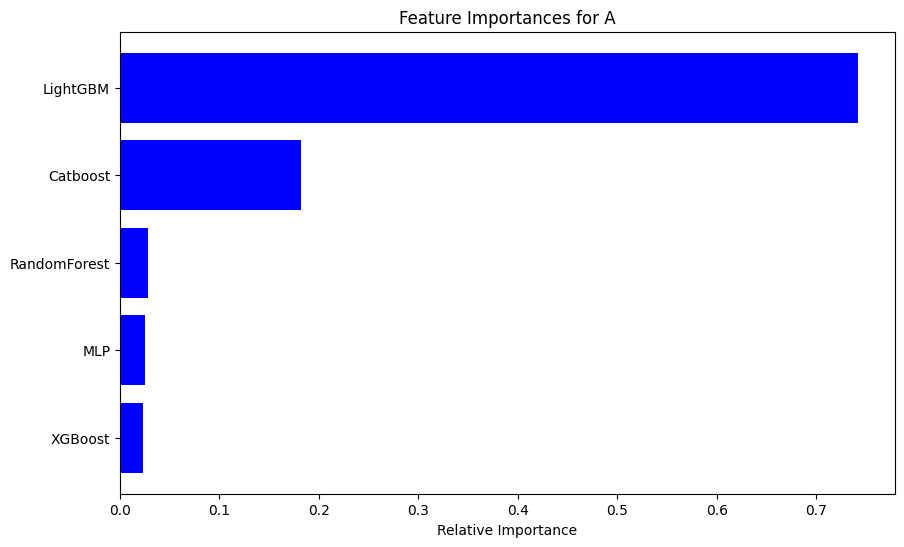

{'Catboost': 60.2924147966966, 'RandomForest': 60.58727115957187, 'LightGBM': 56.94559175369893, 'MLP': 59.006755385407, 'XGBoost': 64.2850922064208}
Model score: 0.9828911443562427


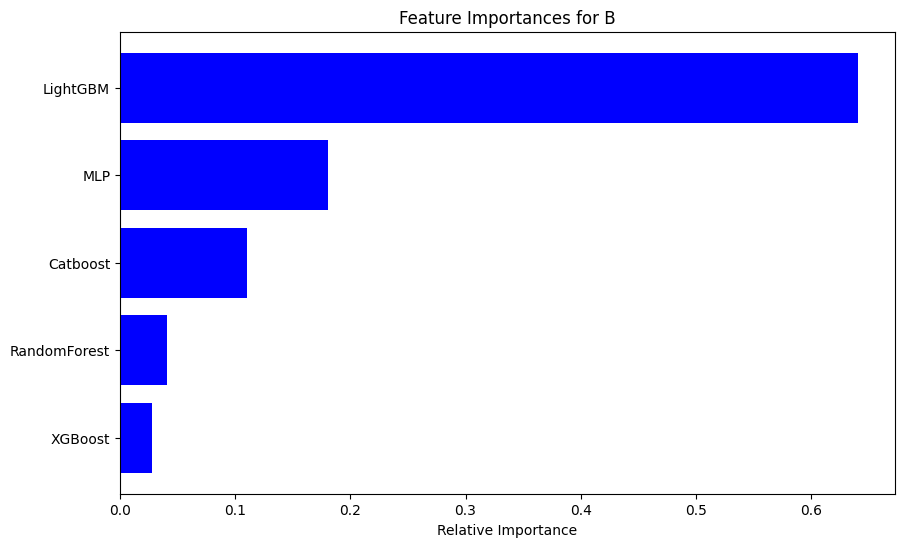

{'Catboost': 46.81474067163569, 'RandomForest': 48.78346137769217, 'LightGBM': 47.25493023029752, 'MLP': 48.17339960303064, 'XGBoost': 52.67617921126694}
Model score: 0.9856590756077225


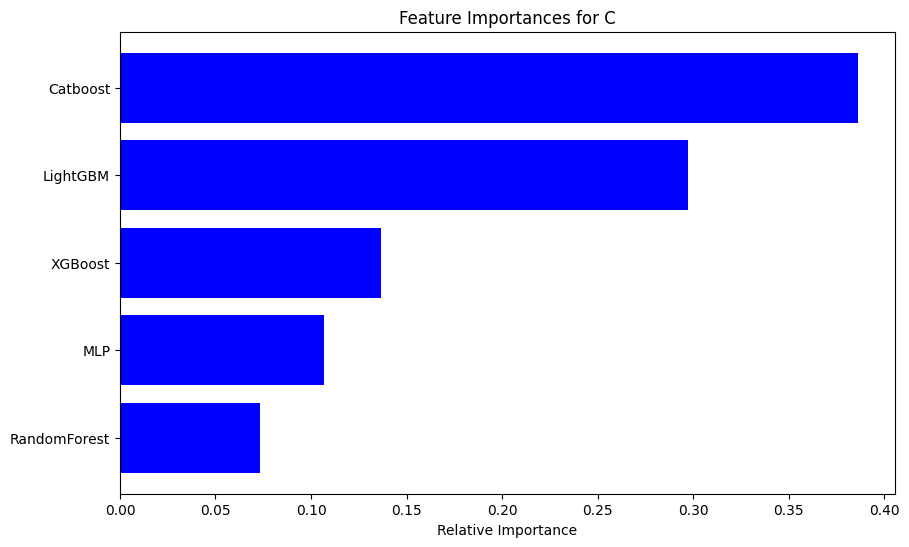

23/23 [==============================] - 0s 662us/step
19.098437013333335


In [8]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.backend import clear_session
import matplotlib.pyplot as plt
import os


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import catboost as cb

import xgboost as xgb
import lightgbm as lgb

def create_model_mlp(num_features, params):
    model = models.Sequential()
    model.add(
        layers.Dense(
            num_features,
            activation="relu",
            kernel_initializer="normal",
            input_shape=(num_features,),
        )
    )
    model.add(layers.Dense(16, activation="relu", kernel_initializer="normal"))
    model.add(layers.Dense(16, activation="relu", kernel_initializer="normal"))
    model.add(layers.Dense(1, kernel_initializer="normal", activation="linear"))

    optimizer = SGD(
        learning_rate=params["learning_rate"],
        momentum=params["momentum"],
    )
    model.compile(loss="mean_absolute_error", optimizer=optimizer)
    return model

def blob(letter):



    A_params=[{'loss_function': 'MAE', 'colsample_bylevel': 0.07524503439954632, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'learning_rate': 0.21457171264708794, 'iterations': 1743, 'l2_leaf_reg': 3.2654906719939096, 'border_count': 125, 'random_strength': 4, 'subsample': 0.9647762909882722},
    {'n_estimators': 728, 'max_depth': 32, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'},
    {'lambda_l1': 0.046833503396687244, 'lambda_l2': 0.006793841288240755, 'num_leaves': 163, 'feature_fraction': 0.929721178994391, 'bagging_fraction': 0.9044770721877625, 'bagging_freq': 6, 'min_child_samples': 16},
    {'learning_rate': 0.0011881356000584273, 'momentum': 0.007427232252863111},
    {'lambda': 4.008350742341045, 'alpha': 0.5938349159130611, 'eta': 0.41872596427506, 'gamma': 0.3960437023698051, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.6306741879739037, 'colsample_bytree': 0.8160324662642783, 'colsample_bylevel': 0.6887672828499098, 'colsample_bynode': 0.6657703558661234}]

    B_params=[{'loss_function': 'MAE', 'colsample_bylevel': 0.0478383929191963, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'learning_rate': 0.2914259300415878, 'iterations': 1482, 'l2_leaf_reg': 0.01173059472637936, 'border_count': 67, 'random_strength': 1},
    {'n_estimators': 1812, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'},
    {'lambda_l1': 0.3292151184937159, 'lambda_l2': 0.00017039816288479435, 'num_leaves': 121, 'feature_fraction': 0.7992531492630386, 'bagging_fraction': 0.9062024635089169, 'bagging_freq': 1, 'min_child_samples': 12},
    {'learning_rate': 0.00040347911788473766, 'momentum': 0.39280565026198133},
    {'lambda': 0.020066610743154346, 'alpha': 0.020699686769877438, 'eta': 0.38009204594957435, 'gamma': 0.019310696968323503, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.7467461954995296, 'colsample_bytree': 0.9341895261741568, 'colsample_bylevel': 0.6869510780278182, 'colsample_bynode': 0.3781649042157331}]

    C_params=[{'loss_function': 'MAE', 'colsample_bylevel': 0.07122595559105349, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'learning_rate': 0.1428232280057889, 'iterations': 1231, 'l2_leaf_reg': 0.03177024578576441, 'border_count': 111, 'random_strength': 7, 'bagging_temperature': 0.5470894828054673},
    {'n_estimators': 1188, 'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'},
    {'lambda_l1': 0.010132697944440957, 'lambda_l2': 1.3131072935454758e-08, 'num_leaves': 46, 'feature_fraction': 0.8270943641777372, 'bagging_fraction': 0.6628880080664098, 'bagging_freq': 4, 'min_child_samples': 19},
    {'learning_rate': 0.0005264021357158383, 'momentum': 0.005758505842856219},
    {'lambda': 4.0646418744914525, 'alpha': 0.01032666426760746, 'eta': 0.5072545314266129, 'gamma': 0.45062371002987023, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.9508152944450243, 'colsample_bytree': 0.5386940634341901, 'colsample_bylevel': 0.5562947611307176, 'colsample_bynode': 0.649251076479528}]

    ens_params = {
        "A": A_params,
        "B": B_params,
        "C": C_params
    }

    df = ensPre.trim(ensPre.readDataSet(letter), [])
    df.columns = ["".join(c if c.isalnum() or c == '_' else '_' for c in str(x)) for x in df.columns]

    X = df.drop(columns=["target"])
    y = df["target"]

    train_x, valid_x, train_y, valid_y, holdout_X, holdout_y  = ensPre.new_train_test_split(X, y, letter,True)
     
    scaler = StandardScaler()
    scaler.fit(train_x)
    X_scaled = scaler.transform(X)
    X_scaled=pd.DataFrame(X_scaled,columns=X.columns,index=X.index)
    train_x_scaled, valid_x_scaled, train_y_scaled, valid_y_scaled,holdout_X_scaled, holdout_y_scaled  = ensPre.new_train_test_split(X_scaled, y,letter,True)

    train_x=pd.concat([train_x,valid_x],axis=0)
    train_y=pd.concat([train_y,valid_y],axis=0)

    train_x_scaled=pd.concat([train_x_scaled,valid_x_scaled],axis=0)
    train_y_scaled=pd.concat([train_y_scaled,valid_y_scaled],axis=0)


    Models={}
    
    study0_model=cb.CatBoostRegressor(**ens_params[letter][0])
    study0_model.fit(train_x,train_y,verbose=0)
    Models["Catboost"]=study0_model

    study1_model=RandomForestRegressor(**ens_params[letter][1])
    study1_model.fit(train_x,train_y)
    Models["RandomForest"]=study1_model

    study2_model=lgb.train(ens_params[letter][2],lgb.Dataset(train_x, label=train_y))
    Models["LightGBM"]=study2_model
    
    study3_model=create_model_mlp(X.shape[1], ens_params[letter][3])
    study3_model.fit(train_x_scaled,train_y_scaled,shuffle=True,
        batch_size=16,
        epochs=100,
        verbose=False)
    Models["MLP"]=study3_model

    study4_model=xgb.train(ens_params[letter][4], xgb.DMatrix(train_x_scaled, label=train_y_scaled), verbose_eval=False)
    Models["XGBoost"]=study4_model
    Models["Scaler"]=scaler
    
    return Models

def predict_base_models(X,base_models):

    predictions = pd.DataFrame()
    scaler = base_models["Scaler"]
    
    X_scaled = scaler.transform(X)
    X_scaled=pd.DataFrame(X_scaled,columns=X.columns,index=X.index)

    for model_name, model in base_models.items():
        # Make predictions with the current model
        if model_name=="MLP":
            pred = model.predict(X_scaled)
        elif model_name=="XGBoost":
            pred = model.predict(xgb.DMatrix(X_scaled))
        elif model_name=="Scaler":
            continue
        else:
            pred = model.predict(X)
        # Add the predictions to the DataFrame
        predictions[model_name] = pred

    return predictions

def prepare_data(letter):
    df = ensPre.trim(ensPre.readDataSet(letter), [])
    df.columns = ["".join(c if c.isalnum() or c == '_' else '_' for c in str(x)) for x in df.columns]

    X = df.drop(columns=["target"])
    y = df["target"]
    train_x, valid_x, train_y, valid_y, holdout_X, holdout_y  = ensPre.new_train_test_split(X, y, letter,True)
    return train_x, valid_x, train_y, valid_y, holdout_X, holdout_y


A_base_models=blob("A")
B_base_models=blob("B")
C_base_models=blob("C")


A_train_x, A_valid_x, A_train_y, A_valid_y, A_holdout_X, A_holdout_y=prepare_data("A")
B_train_x, B_valid_x, B_train_y, B_valid_y, B_holdout_X, B_holdout_y=prepare_data("B")
C_train_x, C_valid_x, C_train_y, C_valid_y, C_holdout_X, C_holdout_y=prepare_data("C")

A_predictions_fitonval=(predict_base_models(A_holdout_X,A_base_models))
B_predictions_fitonval=(predict_base_models(B_holdout_X,B_base_models))
C_predictions_fitonval=(predict_base_models(C_holdout_X,C_base_models))

A_predictions_fitonval["valdid"]=A_holdout_y.values
B_predictions_fitonval["valdid"]=B_holdout_y.values
C_predictions_fitonval["valdid"]=C_holdout_y.values
 
def calculate_mae(predictions_df, valid_column='valdid'):
    mae_scores = {}

    for model_name in predictions_df.columns:
        if model_name != valid_column:
            mae = mean_absolute_error(predictions_df[valid_column], predictions_df[model_name])
            mae_scores[model_name] = mae

    return mae_scores

print(calculate_mae(A_predictions_fitonval))
print(calculate_mae(B_predictions_fitonval))
print(calculate_mae(C_predictions_fitonval))

def trainmeta(letter):

    train_x, valid_x, train_y, valid_y,holdout_X, holdout_y  = prepare_data(letter)
    train_x=pd.concat([train_x,valid_x,holdout_X],axis=0)
    train_y=pd.concat([train_y,valid_y,holdout_y],axis=0)

    # Replace 'A' with 'letter'
    predictions_fitonval = globals()[f'{letter}_predictions_fitonval']
    X_meta = predictions_fitonval[["Catboost","RandomForest","LightGBM","MLP","XGBoost"]]
    y_meta = holdout_y

    mae_values = {}
    for column in predictions_fitonval[["Catboost","RandomForest","LightGBM","MLP","XGBoost"]]:
    
        mae = mean_absolute_error(y_meta, predictions_fitonval[column])
        mae_values[column] = mae

    print(mae_values)

    # Create and train the Linear Regression model
    meta_model = RandomForestRegressor(n_estimators=100, random_state=42)
    meta_model.fit(X_meta, y_meta)

    # Score the model
    score = meta_model.score(X_meta, y_meta)
    print(f"Model score: {score}")

    # Make predictions and add them to the DataFrame

    # Save the DataFrame to a CSV file
# Get feature importances
    importances = meta_model.feature_importances_

    # Get the indices of the importances sorted by their values
    indices = np.argsort(importances)

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importances for {letter}')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [X_meta.columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    return meta_model


meta_A=trainmeta("A")
meta_B=trainmeta("B")
meta_C=trainmeta("C")



A_stats=ensPre.calculate_hourly_monthly_means(ensPre.clean(ensPre.readDataSet("A")))
A_x_test=ensPre.readtest("A")
A_x_test=ensPre.preptest(A_x_test,[],A_stats)

B_stats=ensPre.calculate_hourly_monthly_means(ensPre.clean(ensPre.readDataSet("B")))
B_x_test=ensPre.readtest("B")
B_x_test=ensPre.preptest(B_x_test,[],B_stats)

C_stats=ensPre.calculate_hourly_monthly_means(ensPre.clean(ensPre.readDataSet("C")))
C_x_test=ensPre.readtest("C")
C_x_test=ensPre.preptest(C_x_test,[],C_stats)


A_base_preds=(predict_base_models(A_x_test,A_base_models))
B_base_preds=(predict_base_models(B_x_test,B_base_models))
C_base_preds=(predict_base_models(C_x_test,C_base_models))

A_y_pred=meta_A.predict(A_base_preds)
B_y_pred=meta_B.predict(B_base_preds)
C_y_pred=meta_C.predict(C_base_preds)

A_y_pred=pd.DataFrame(A_y_pred, index=A_x_test.index, columns=['y_pred'])
print(0.016*A_y_pred["y_pred"].mean())
A_y_pred[A_y_pred["y_pred"]<0.0016*A_y_pred["y_pred"].mean()]=0

B_y_pred=pd.DataFrame(B_y_pred, index=B_x_test.index, columns=['y_pred'])
B_y_pred[B_y_pred["y_pred"]<0.0016*B_y_pred["y_pred"].mean()]=0
C_y_pred=pd.DataFrame(C_y_pred, index=C_x_test.index, columns=['y_pred'])
C_y_pred[C_y_pred["y_pred"]<0.0016*C_y_pred["y_pred"].mean()]=0


combined_pred = pd.concat([A_y_pred, B_y_pred, C_y_pred], axis=0)
combined_pred["y_pred"] = combined_pred["y_pred"].clip(lower=0)
combined_pred.to_csv("combined_pred.csv", index=True)
combined_pred=(pd.read_csv("combined_pred.csv"))

# Add the "Id" column
combined_pred.insert(0, "id", range(len(combined_pred)))
combined_pred = combined_pred.rename(columns={combined_pred.columns[-1]: "prediction"})
combined_pred[["id", "prediction"]].to_csv(f"{FOLDER_NAME}/Ensemble_prediction.csv", index=False)
os.remove("combined_pred.csv")

## stacking with weights csvfiles

In [9]:
#wheights chosen from intuition and trial.
dataframes = {}
for filename in os.listdir(FOLDER_NAME):
    if filename.endswith('.csv'):  # Check if the file is a CSV
        file_path = os.path.join(FOLDER_NAME, filename)
        dataframe_name = filename.split('.')[0]  # Get the name of the file without the extension
        dataframes[dataframe_name] = pd.read_csv(file_path)

data = dataframes["Ensemble_prediction"]["prediction"]*0.2 + dataframes["DNN"]["prediction"]*0.4 + dataframes["flaml_quarters"]["prediction"]*0.4
data = pd.DataFrame(data, columns=["prediction"])


data.index.name = "id"


data.to_csv("Short_notebook1_submit.csv")


